# VARIETY MATURITY DISTRIBUTION AND CHANGE OVER TIME

In [ ]:
"""
Plot   - Distribution of maize cultivar maturity in Africa a) and c) Primary and second maize 
         Static cultivar maturity distribution and dominant sowing month
         with Y^2/100*SD for 50 years as the criteria 
         Culitivar maturity migration b) and d) Primary and second maize
         
         Using wfer_GT1 with optimumfixed sow.  
"""

In [1]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.transform import from_origin
import itertools
import statsmodels.api as sm

In [2]:
crop="mz"
fer="wfer_wa38hi40"
G1="_GT1" #or _G1 #if remove grids that over >80% yearly yield is less than 1

In [3]:
#merge data and save as a tiff file
#function to transfer csv to tif file
def csv2tif(csvinput,outtif,lon_col='x',lat_col='y',value_col='value'):
    """
    Convert a csv file with latitude, longitude and value columns to a GeoTIFF
    """
    df=csvinput#pd.read_csv(csvinput)
    lons=df[lon_col].values
    lats=df[lat_col].values
    values=df[value_col].values
    df=df.dropna() #remove rows with NaN values in latitude, longitude or value
    min_lon,max_lon=np.min(lons),np.max(lons)
    min_lat,max_lat=np.min(lats),np.max(lats)
    resolution=0.1 #define resolution
    rows=int((max_lat-min_lat)/resolution)+1 #create the output raster
    cols=int((max_lon-min_lon)/resolution)+1
   
    raster=np.full((rows,cols),np.nan) #Initialize with NaN values
    #Populate the raster based on dataframe values
    for lat,lon,value in zip(lats,lons,values):
        col=int((lon-min_lon)/resolution)
        row=int((max_lat-lat)/resolution)
        if 0<=row<rows and 0<=col<cols: #check bounds
            raster[row,col]=value
    transform=from_origin(min_lon,max_lat,resolution,resolution) #create transform
    #Write the raster to a GeoTIFF file
    with rasterio.open(
            outtif,
            'w',
            driver='GTiff',
            height=raster.shape[0],
            width=raster.shape[1],
            count=1,
            dtype=rasterio.float32, #Use float32 to stor NaN values
            crs='EPSG:4326',     #Geographic coordinate system
            transform=transform
            ) as dst:
                dst.write(raster,1)

# Results for grids that the chance with yield >1 t/ha is greater than 80%

In [13]:
#Convert cultivar maturity distribution (mean) to tif files
data=pd.read_csv("D:/works/AfricaMzSg/input/African5minGrid_SIMUNIT.csv")
#df<-read.csv(gridfile,header=T)
infile="D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_culseg_"+fer+"_1971-2021"+G1+".csv"  #Change for file
temp=pd.read_csv(infile)
data=data.merge(temp,on="SIMUNIT",how="inner")[['POINT_X','POINT_Y','sea1_matugroup','sea1_dominantmon','sea1_nGT1',
                                                'sea2_matugroup','sea2_dominantmon','sea2_nGT1']]
data.columns=['x','y','s1c','s1m','s1GT1','s2c','s2m','s2GT1']
#save column value as a tiff file
#Export result as tif raster
for se in ['1','2']: #sea1 and sea2
    df=data[data['s'+se+'GT1']>=(0.8*51)][['x','y','s'+se+'c','s'+se+'m']].dropna()
    df.to_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_se"+se+"_"+fer+"_dis_withmon"+G1+".csv",index=False)
    df=df[['x','y','s'+se+'c']]
    df.columns=['x','y','value']
    df.to_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_se"+se+"_"+fer+"_dis"+G1+".csv",index=False)
    csv2tif(df,"D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_se"+se+"_"+fer+"_dis"+G1+".tiff")

In [14]:
#Estimate the temporal change of cultivar maturity group across all grids. 
period=['1971-1980','1981-1990','1991-2000','2001-2010','2011-2021']
i=0
in_dir="D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"
df=pd.read_csv(in_dir+crop+"_culseg_"+fer+"_"+period[i]+G1+".csv")
df.loc[df['sea1_nGT1']<8,'sea1_matugroup']=np.nan
df.loc[df['sea2_nGT1']<8,'sea2_matugroup']=np.nan
df=df[['SIMUNIT','sea1_matugroup','sea1_dominantmon','sea2_matugroup','sea2_dominantmon']]
df.columns=["SIMUNIT"]+["se1c_"+str(i),"se1m_"+str(i),"se2c_"+str(i),"se2m_"+str(i)]
for i in range(1,5):
    temp=pd.read_csv(in_dir+crop+"_culseg_"+fer+"_"+period[i]+G1+".csv")
    temp.loc[temp['sea1_nGT1']<8,'sea1_matugroup']=np.nan
    temp.loc[temp['sea2_nGT1']<8,'sea2_matugroup']=np.nan
    temp=temp[['SIMUNIT','sea1_matugroup','sea1_dominantmon','sea2_matugroup','sea2_dominantmon']]
    temp.columns=["SIMUNIT","se1c_"+str(i),"se1m_"+str(i),"se2c_"+str(i),"se2m_"+str(i)]
    df=df.merge(temp)
df=df[["SIMUNIT"]+[col for col in df.columns if "se1c" in col]+[col for col in df.columns if "se2c" in col]]
for se in [1,2]:
    slope=[]
    intercept=[]
    pvalue=[]
    for rowi in range(df.shape[0]):
        y=df.iloc[rowi,(1+(se-1)*5):(6+(se-1)*5)]
        x=np.arange(len(y))
        x=sm.add_constant(x)
        model=sm.OLS(y,x)
        results=model.fit()
        slope=slope+[round(results.params[1],1)]
        intercept=intercept+[round(results.params[1],0)]
        pvalue=pvalue+[round(results.pvalues[1],3)]
    df['slope_'+str(se)]=slope
    df['intercept_'+str(se)]=intercept
    df['pvalue_'+str(se)]=pvalue
df.to_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_culseg_"+fer+"_cul_temporalChange"+G1+".csv",index=False)

In [15]:
#Convert cultivar maturity migraation to tif files 
#Get the information where has migration and latitude and longitude
#-1: to early, 0: no change, 1: to later
def create_new_column(row):
    if np.isnan(row[0]) or np.isnan(row[1]):
        return np.nan
    else:
        if row[0] > 0 and row[1] <= 0.1:
            return 2
        elif row[0] > 0 and row[1] > 0.1:
            return 1
        elif row[0] < 0 and row[1] <= 0.1:
            return -2
        elif row[0] <0 and row[1] > 0.1:
            return -1
        else:
            return 0
temp=pd.read_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_culseg_"+fer+"_cul_temporalChange"+G1+".csv")[['SIMUNIT','slope_1','pvalue_1','slope_2','pvalue_2']]
temp['se1'] = temp[['slope_1','pvalue_1']].apply(create_new_column, axis=1)
temp['se2'] = temp[['slope_2','pvalue_2']].apply(create_new_column, axis=1)
temp=temp[['SIMUNIT','se1','se2']]
df=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
df=df[['SIMUNIT','POINT_X','POINT_Y','A']]
df.columns=['SIMUNIT','x','y','A']
df=df.merge(temp)
#save it as a tif
for se in ['se1','se2']:
    temp=df[['x','y',se]]
    temp.columns=['x','y','value']
    temp=temp.dropna()
    #keep it has the same domain as the distribution map
    yld=pd.read_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_"+se+"_"+fer+"_dis"+G1+".csv")[['x','y']]
    temp=yld.merge(temp,how='left').fillna(0)
    temp.to_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_"+se+"_"+fer+"_change"+G1+".csv",index=False)
    csv2tif(temp,"D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_"+se+"_"+fer+"_change"+G1+".tiff")

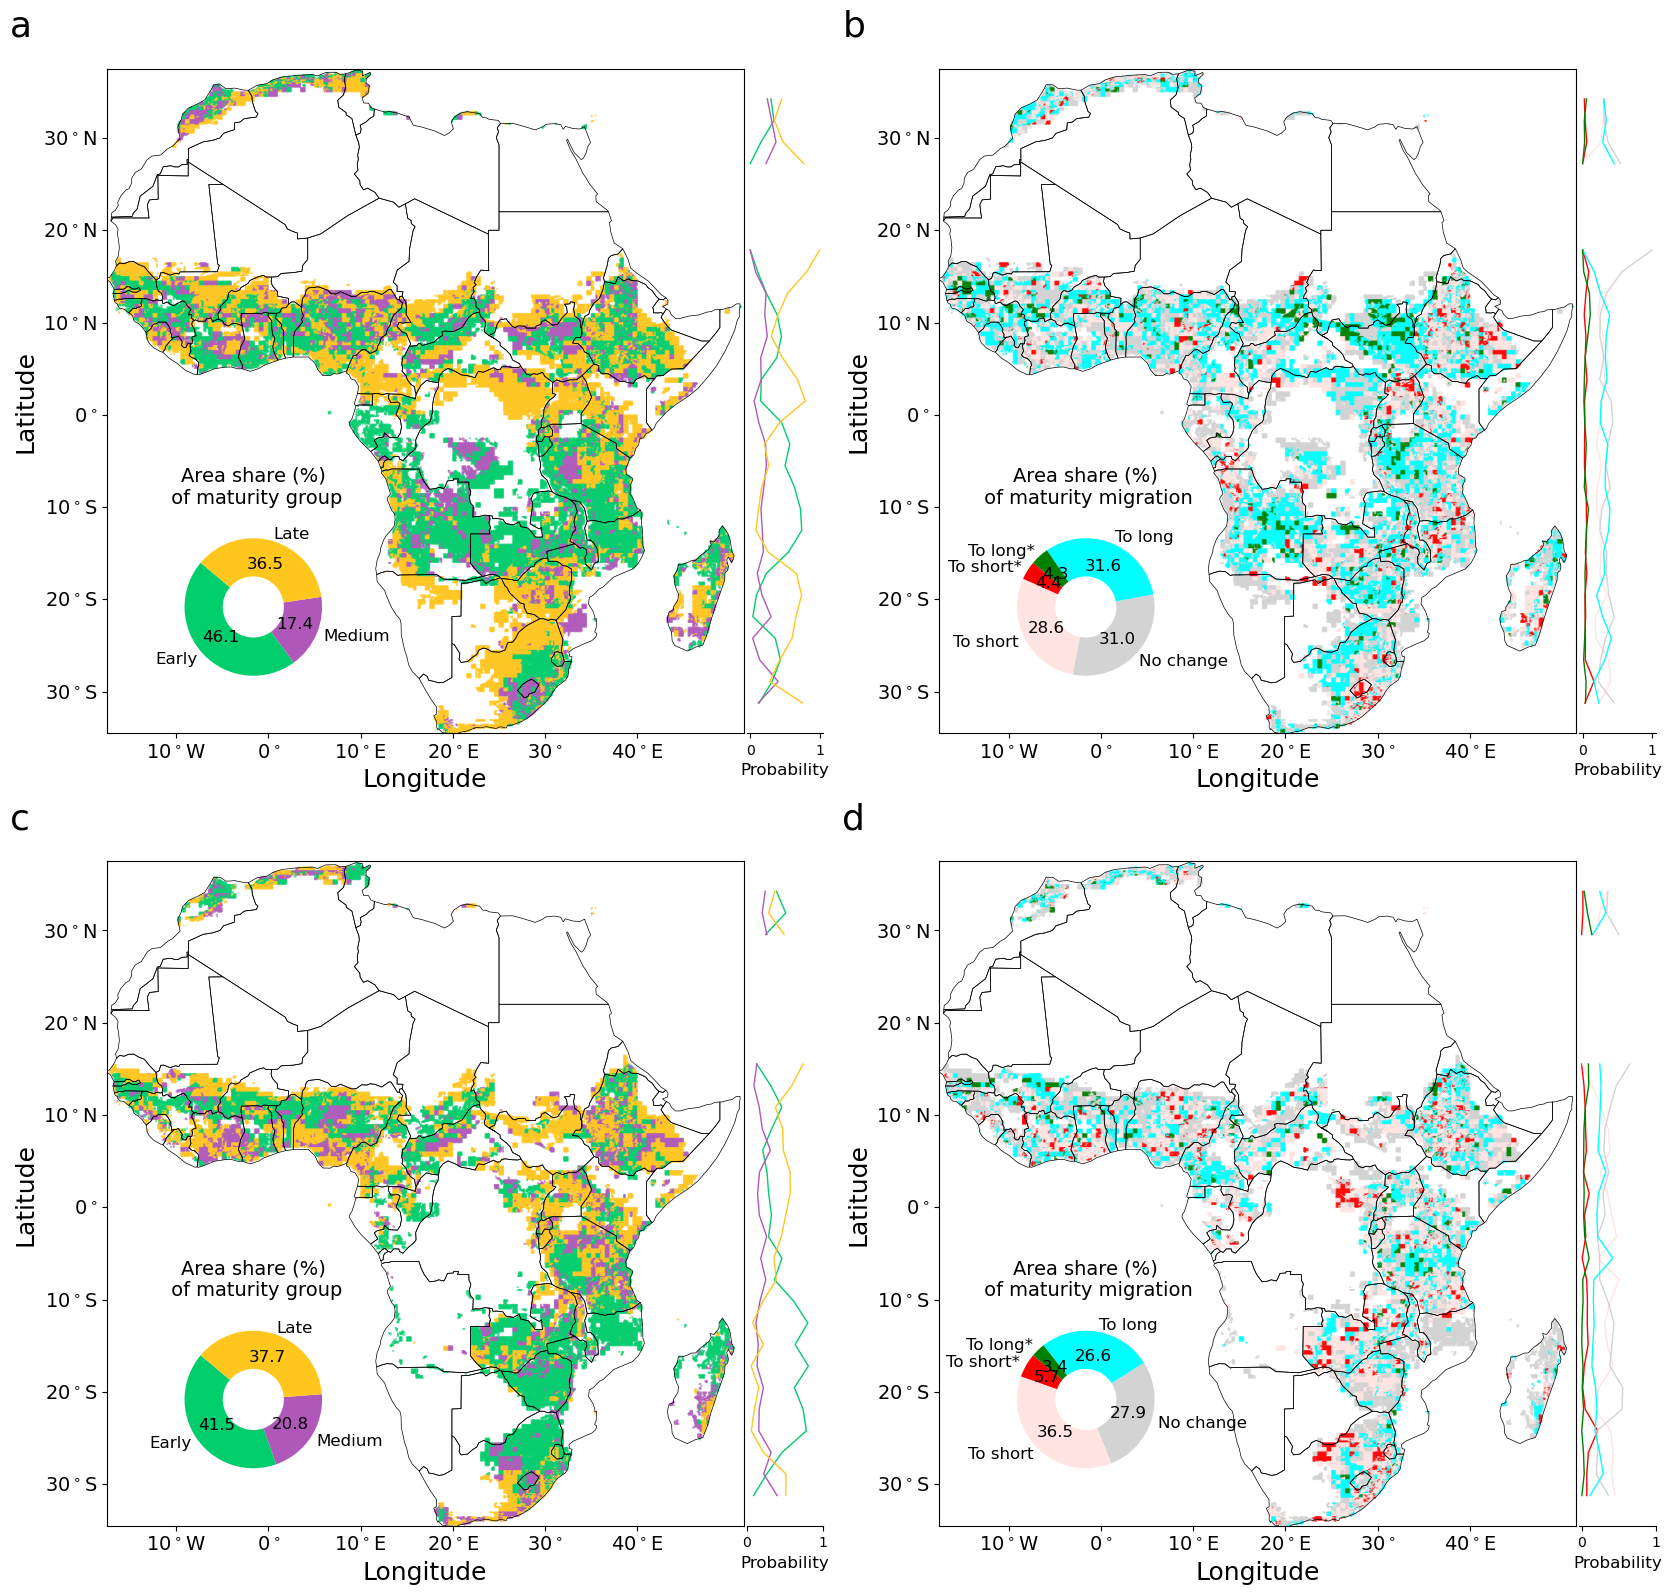

In [16]:
"""
Plotting
"""
in_dir="D:\\works\\AfricaMzSg\\results\\"+crop+"\\"+fer+"\\"
tif_dir="D:\\works\\AfricaMzSg\\results\\"+crop+"\\"+fer+"\\"
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\"
#Define color
type_colors = [{-1: "#00CD6C", 0: "#AF58BA", 1: "#FFC61E"},
               {-2: "red", -1: "mistyrose", 0: "lightgrey", 1: "cyan", 2: "green"}] #blue, red, green, maturity type 
change_colors = {-2: "red", -1: "mistyrose", 0: "lightgrey", 1: "cyan", 2: "blue"} #change
#African country bounday
africa=gpd.read_file(fig_dir+"CountryBoundaryLines\\ne_110m_admin_0_countries.shp")
africa=africa[africa['CONTINENT']=='Africa']
#type_colors = {-1: "#E9002D", 0: "#FFAA00", 1: "#00B000"}  #Red Amber Green
tif_type=['dis','change']
pie_title=['Area share (%)\n of maturity group','Area share (%)\n of maturity migration']
pie_label=[['Early','Medium','Late'],
           ['To short*','To short','No change','To long','To long*']]
pie_radius=[0.9,0.9]
#grid include maize area
grid=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")[['POINT_X','POINT_Y','A']]
grid.columns=['x','y','A']
fig, axs = plt.subplots(2,2,figsize=(16.8,16))
#axs.axis("off") 
for i,j in list(itertools.product(range(2),range(2))):  #i=season, j=dist or change
    tif=tif_dir+"mz_se"+str(i+1)+"_"+fer+"_"+tif_type[j]+G1+".tiff"  #tif file for plotting
    df=pd.read_csv(in_dir+"mz_se"+str(i+1)+"_"+fer+"_"+tif_type[j]+G1+".csv") #data file for computer area sharing
    df=df.merge(grid).dropna()[['value','A']] #only leave value and Area columns
    with rasterio.open(tif) as src:
        tif = src.read(1)  # 读取第一个波段数据
        transform = src.transform  # 获取仿射变换参数
    #Acquire row and col number
    rows, cols = np.meshgrid(np.arange(tif.shape[0]),np.arange(tif.shape[1]),indexing='ij')  # 获取地理范围
    #Convert row and col to geospatial coordination
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)
    #Convert grid value and latitude longitude into dataframe
    data = pd.DataFrame({
        "longitude": xs.ravel(),
        "latitude": ys.ravel(),
        "value": tif.ravel()
    })
    #remove NaN values
    data = data[data["value"] != src.nodata]

    #Convert data into GeoDataFrame
    geometry = [Point(xy) for xy in zip(data["longitude"], data["latitude"])]
    geo_data = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")
       
    #main distribution plot at the middle
    ax_main = axs[i,j]
    africa.boundary.plot(ax=ax_main, linewidth=0.5, color="black")
    geo_data.plot(
        ax=ax_main,
        column="value",
        cmap=plt.cm.colors.ListedColormap([type_colors[j][key] for key in [*type_colors[j]]]),
        #legend=True,
        markersize=0.1)
    
    #ax_main.set_title("Maize maurity group distribution",fontsize=16)
    ax_main.set_xlabel("Longitude", fontsize=18)
    ax_main.set_ylabel("Latitude", fontsize=18)
    ax_main.set_xlim([-17.5,51.5])
    ax_main.set_ylim([-34.5,37.5])
    ax_main.set_xticks([-10,0,10,20,30,40],
                       ['$10^\circ$W','$0^\circ$','$10^\circ$E','$20^\circ$E','$30^\circ$',
                        '$40^\circ$E'],fontsize=14)
    ax_main.set_yticks([-30,-20,-10,0,10,20,30],
                       ['$30^\circ$S','$20^\circ$S','$10^\circ$S','$0^\circ$','$10^\circ$N','$20^\circ$N',
                        '$30^\circ$N'],fontsize=14)
    
    #Pie plot at the left bottom
    ax_pie = ax_main.inset_axes([0.08,0.04,0.3,0.3])   
    sizes = (df.groupby('value').sum()*100/df['A'].sum()).reset_index()['A'].tolist() #[-1,0,1]
    ax_pie.pie(sizes, 
               labels=pie_label[j],  #
               textprops={'fontsize': 12},
               radius=pie_radius[i],
               colors=[type_colors[j][key] for key in [*type_colors[j]]], 
               autopct=lambda pct: f'{pct:.1f}',
               pctdistance=0.65, 
               labeldistance=1.1, 
               rotatelabels=False,
               wedgeprops=dict(width=0.5),
               startangle=-220)
               #autopct=lambda pct: f'{pct:.1f}', startangle=90, wedgeprops=dict(width=0.5))  #'%1.0f%%'
    ax_pie.set_title(pie_title[j],fontsize=14)
    ax_pie.set_aspect('equal')
    ax_pie.set_xticks([])
    ax_pie.set_yticks([])
    
     #KDE plt at right
    ax_dist = ax_main.inset_axes([1.005,0,0.12,1])
    
    latitude_bins = np.linspace(data["latitude"].min(), data["latitude"].max(), 30)
    data["latitude_bins"]=pd.cut(data["latitude"],bins=latitude_bins,include_lowest=True)
    p_table=data.groupby(['latitude_bins','value']).size().unstack(fill_value=0)
    p_table=p_table.div(p_table.sum(axis=1),axis=0)
    c_p=p_table.cumsum(axis=1)

    for value in [*type_colors[j]]:
        ax_dist.plot(p_table[value],
                    latitude_bins[:-1]+np.diff(latitude_bins)/2,
                    linewidth=1,
                    color=type_colors[j][value])
    ax_dist.set_yticks([])
    ax_dist.set_xticks([0,1])
    ax_dist.spines['right'].set_visible(False)
    ax_dist.spines['top'].set_visible(False)
    ax_dist.spines['left'].set_visible(False)
    ax_dist.set_xlabel("Probability",fontsize=12)
for i in range(4):axs[i//2,i%2].text(-28,41,chr(97+i),fontsize=26)

plt.subplots_adjust(wspace=0.03,hspace=0.16)      
fig.tight_layout()
plt.show()
fig.savefig(fig_dir+"MS\\wfer\\MS1_mz_cul_distribution_change_"+fer+G1+".png",format="png",dpi=300)
fig.savefig(fig_dir+"MS\\wfer\\MS1_mz_cul_distribution_change_"+fer+G1+".pdf",format="pdf",dpi=300)

In [17]:
fig.savefig(fig_dir+"MS\\wfer\\MS1_mz_cul_distribution_change_"+fer+G1+".png",format="png",dpi=300)
fig.savefig(fig_dir+"MS\\wfer\\MS1_mz_cul_distribution_change_"+fer+G1+".pdf",format="pdf",dpi=300)

# Results for grids with all reported maize physical area

In [86]:
crop="mz"
fer="wfer_wa40hi45"
G1="" #or _G1 #if remove grids that over >80% yearly yield is less than 1
data=pd.read_csv("D:/works/AfricaMzSg/input/African5minGrid_SIMUNIT.csv")
#df<-read.csv(gridfile,header=T)
infile="D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_culseg_"+fer+"_1971-2021"+G1+".csv"  #Change for file
temp=pd.read_csv(infile)
data=data.merge(temp,on="SIMUNIT",how="inner")[['POINT_X','POINT_Y','sea1_matugroup','sea1_dominantmon','sea1_nGT1',
                                                'sea2_matugroup','sea2_dominantmon','sea2_nGT1']]
data.columns=['x','y','s1c','s1m','s1GT1','s2c','s2m','s2GT1']
#save column value as a tiff file
#Export result as tif raster
for se in ['1','2']: #sea1 and sea2
    df=data[['x','y','s'+se+'c','s'+se+'m']].dropna()   #[data['s'+se+'GT1']>=(0.8*51)]
    df.to_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_se"+se+"_"+fer+"_dis_withmon.csv",index=False)
    df=df[['x','y','s'+se+'c']]
    df.columns=['x','y','value']
    df.to_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_se"+se+"_"+fer+"_dis.csv",index=False)
    csv2tif(df,"D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_se"+se+"_"+fer+"_dis.tiff")
    
#Estimate the temporal change of cultivar maturity group across all grids. 
period=['1971-1980','1981-1990','1991-2000','2001-2010','2011-2021']
i=0
in_dir="D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"
df=pd.read_csv(in_dir+crop+"_culseg_"+fer+"_"+period[i]+".csv")
#df.loc[df['sea1_nGT1']<8,'sea1_matugroup']=np.nan
#df.loc[df['sea2_nGT1']<8,'sea2_matugroup']=np.nan
df=df[['SIMUNIT','sea1_matugroup','sea1_dominantmon','sea2_matugroup','sea2_dominantmon']]
df.columns=["SIMUNIT"]+["se1c_"+str(i),"se1m_"+str(i),"se2c_"+str(i),"se2m_"+str(i)]
for i in range(1,5):
    temp=pd.read_csv(in_dir+crop+"_culseg_"+fer+"_"+period[i]+".csv")
    #temp.loc[temp['sea1_nGT1']<8,'sea1_matugroup']=np.nan
    #temp.loc[temp['sea2_nGT1']<8,'sea2_matugroup']=np.nan
    temp=temp[['SIMUNIT','sea1_matugroup','sea1_dominantmon','sea2_matugroup','sea2_dominantmon']]
    temp.columns=["SIMUNIT","se1c_"+str(i),"se1m_"+str(i),"se2c_"+str(i),"se2m_"+str(i)]
    df=df.merge(temp)
df=df[["SIMUNIT"]+[col for col in df.columns if "se1c" in col]+[col for col in df.columns if "se2c" in col]]
for se in [1,2]:
    slope=[]
    intercept=[]
    pvalue=[]
    for rowi in range(df.shape[0]):
        y=df.iloc[rowi,(1+(se-1)*5):(6+(se-1)*5)]
        x=np.arange(len(y))
        x=sm.add_constant(x)
        model=sm.OLS(y,x)
        results=model.fit()
        slope=slope+[round(results.params[1],1)]
        intercept=intercept+[round(results.params[1],0)]
        pvalue=pvalue+[round(results.pvalues[1],3)]
    df['slope_'+str(se)]=slope
    df['intercept_'+str(se)]=intercept
    df['pvalue_'+str(se)]=pvalue
df.to_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_culseg_"+fer+"_cul_temporalChange.csv",index=False)

#Convert cultivar maturity migraation to tif files 
#Get the information where has migration and latitude and longitude
#-1: to early, 0: no change, 1: to later
def create_new_column(row):
    if np.isnan(row[0]) or np.isnan(row[1]):
        return np.nan
    else:
        if row[0] > 0 and row[1] <= 0.1:
            return 2
        elif row[0] > 0 and row[1] > 0.1:
            return 1
        elif row[0] < 0 and row[1] <= 0.1:
            return -2
        elif row[0] <0 and row[1] > 0.1:
            return -1
        else:
            return 0
temp=pd.read_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_culseg_"+fer+"_cul_temporalChange_GT1.csv")[['SIMUNIT','slope_1','pvalue_1','slope_2','pvalue_2']]
temp['se1'] = temp[['slope_1','pvalue_1']].apply(create_new_column, axis=1)
temp['se2'] = temp[['slope_2','pvalue_2']].apply(create_new_column, axis=1)
temp=temp[['SIMUNIT','se1','se2']]
df=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
df=df[['SIMUNIT','POINT_X','POINT_Y','A']]
df.columns=['SIMUNIT','x','y','A']
df=df.merge(temp)
#save it as a tif
for se in ['se1','se2']:
    temp=df[['x','y',se]]
    temp.columns=['x','y','value']
    temp=temp.dropna()
    #keep it has the same domain as the distribution map
    yld=pd.read_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_"+se+"_"+fer+"_dis.csv")[['x','y']]
    temp=yld.merge(temp,how='left').fillna(0)
    temp.to_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_"+se+"_"+fer+"_change.csv",index=False)
    csv2tif(temp,"D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_"+se+"_"+fer+"_change.tiff")

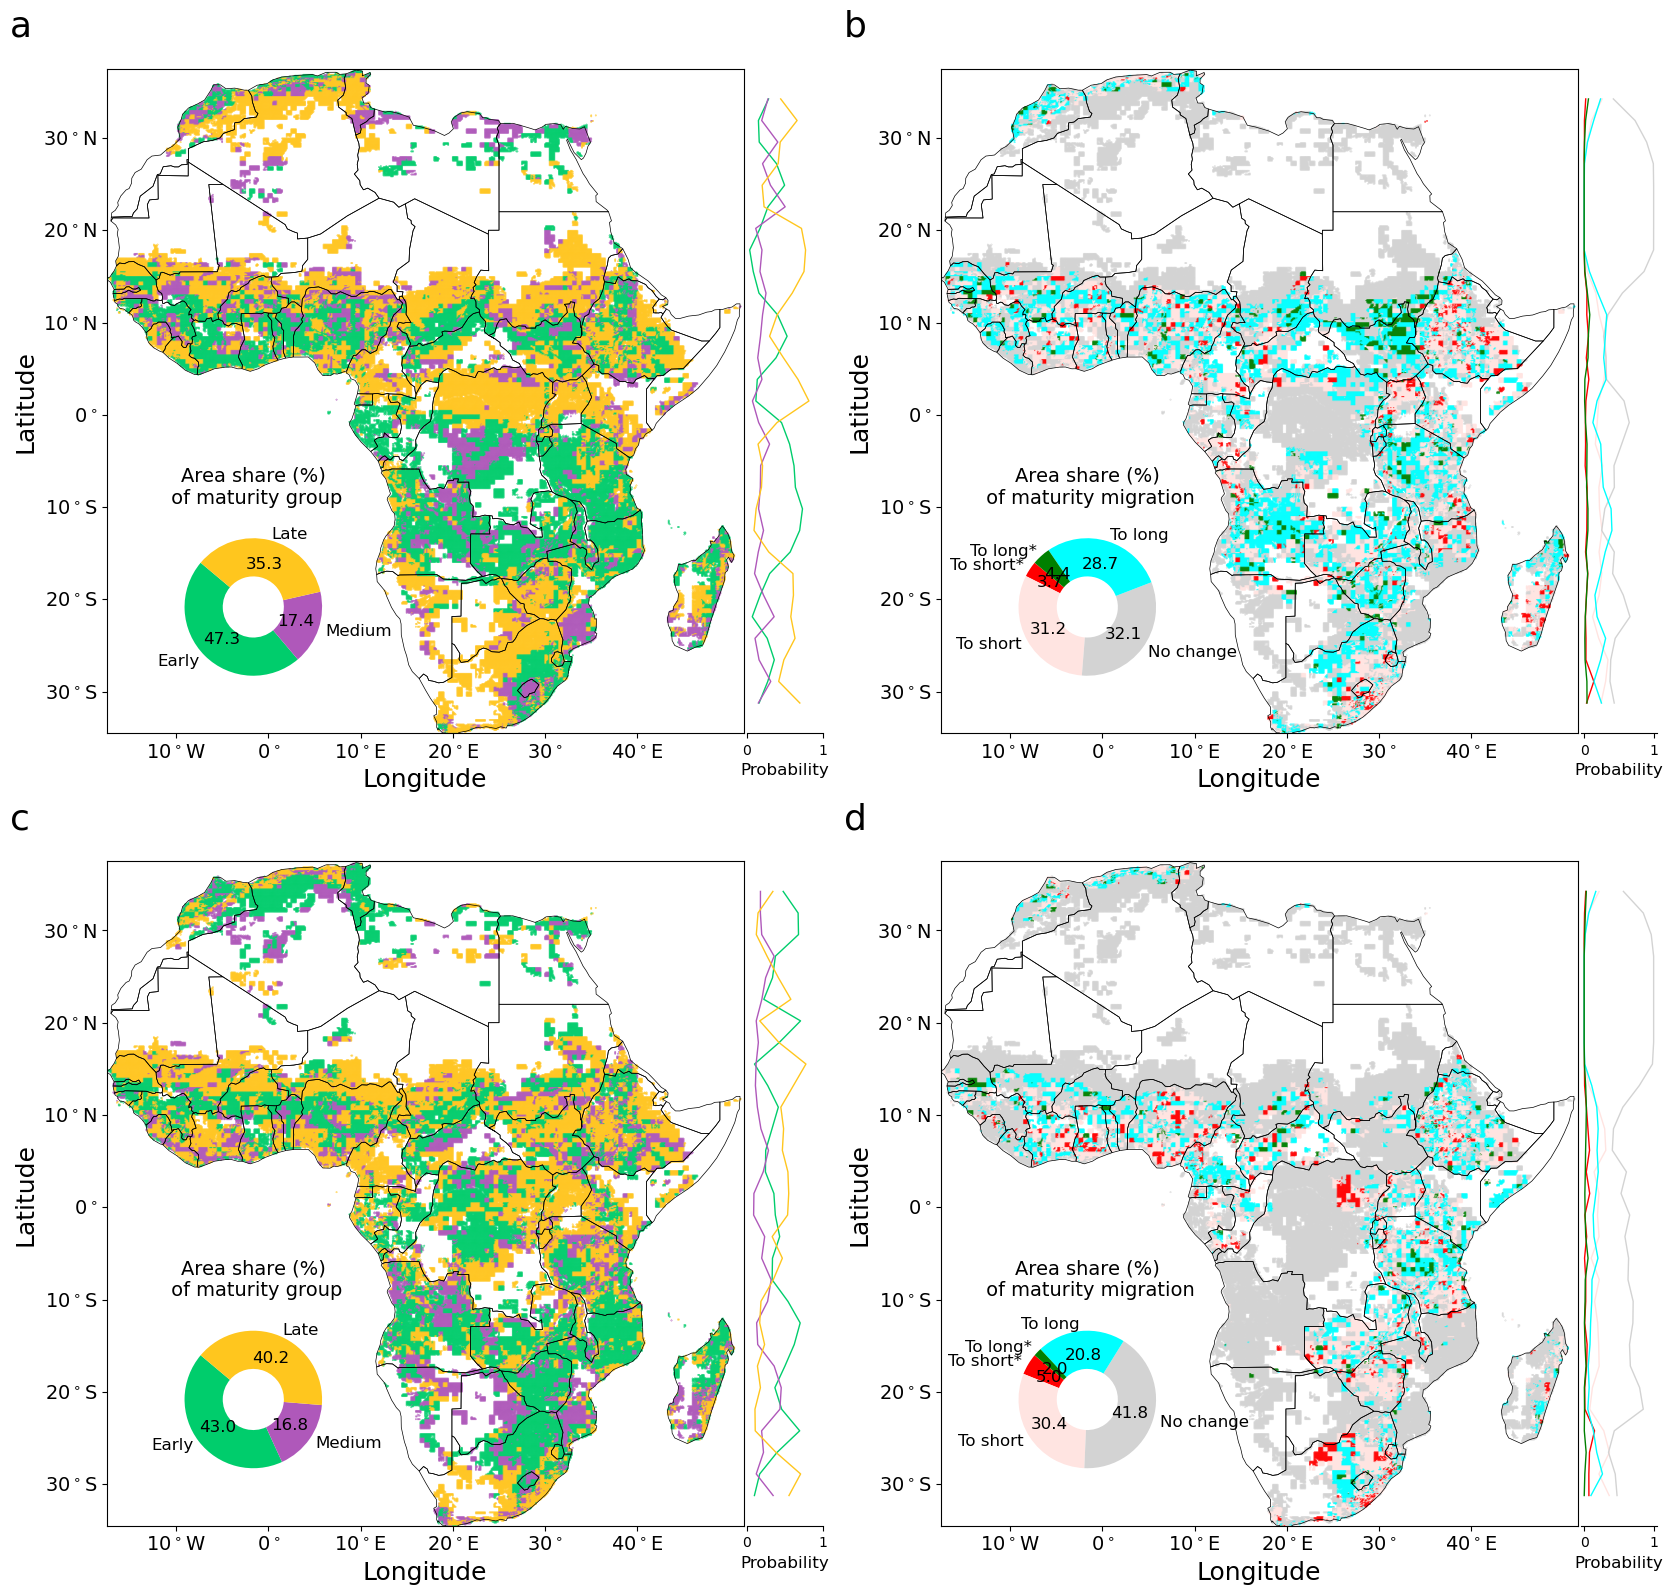

In [14]:
"""
Plotting
"""
in_dir="D:\\works\\AfricaMzSg\\results\\"+crop+"\\"+fer+"\\"
tif_dir="D:\\works\\AfricaMzSg\\results\\"+crop+"\\"+fer+"\\"
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\"
#Define color
type_colors = [{-1: "#00CD6C", 0: "#AF58BA", 1: "#FFC61E"},
               {-2: "red", -1: "mistyrose", 0: "lightgrey", 1: "cyan", 2: "green"}] #blue, red, green, maturity type 
change_colors = {-2: "red", -1: "mistyrose", 0: "lightgrey", 1: "cyan", 2: "blue"} #change
#African country bounday
africa=gpd.read_file(fig_dir+"CountryBoundaryLines\\ne_110m_admin_0_countries.shp")
africa=africa[africa['CONTINENT']=='Africa']
#type_colors = {-1: "#E9002D", 0: "#FFAA00", 1: "#00B000"}  #Red Amber Green
tif_type=['dis','change']
pie_title=['Area share (%)\n of maturity group','Area share (%)\n of maturity migration']
pie_label=[['Early','Medium','Late'],
           ['To short*','To short','No change','To long','To long*']]
pie_radius=[0.9,0.9]
#grid include maize area
grid=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")[['POINT_X','POINT_Y','A']]
grid.columns=['x','y','A']
fig, axs = plt.subplots(2,2,figsize=(16.8,16))
#axs.axis("off") 
for i,j in list(itertools.product(range(2),range(2))):  #i=season, j=dist or change
    tif=tif_dir+"mz_se"+str(i+1)+"_"+fer+"_"+tif_type[j]+".tiff"  #tif file for plotting
    df=pd.read_csv(in_dir+"mz_se"+str(i+1)+"_"+fer+"_"+tif_type[j]+".csv") #data file for computer area sharing
    df=df.merge(grid).dropna()[['value','A']] #only leave value and Area columns
    with rasterio.open(tif) as src:
        tif = src.read(1)  # 读取第一个波段数据
        transform = src.transform  # 获取仿射变换参数
    #Acquire row and col number
    rows, cols = np.meshgrid(np.arange(tif.shape[0]),np.arange(tif.shape[1]),indexing='ij')  # 获取地理范围
    #Convert row and col to geospatial coordination
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)
    #Convert grid value and latitude longitude into dataframe
    data = pd.DataFrame({
        "longitude": xs.ravel(),
        "latitude": ys.ravel(),
        "value": tif.ravel()
    })
    #remove NaN values
    data = data[data["value"] != src.nodata]

    #Convert data into GeoDataFrame
    geometry = [Point(xy) for xy in zip(data["longitude"], data["latitude"])]
    geo_data = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")
       
    #main distribution plot at the middle
    ax_main = axs[i,j]
    africa.boundary.plot(ax=ax_main, linewidth=0.5, color="black")
    geo_data.plot(
        ax=ax_main,
        column="value",
        cmap=plt.cm.colors.ListedColormap([type_colors[j][key] for key in [*type_colors[j]]]),
        #legend=True,
        markersize=0.1)
    
    #ax_main.set_title("Maize maurity group distribution",fontsize=16)
    ax_main.set_xlabel("Longitude", fontsize=18)
    ax_main.set_ylabel("Latitude", fontsize=18)
    ax_main.set_xlim([-17.5,51.5])
    ax_main.set_ylim([-34.5,37.5])
    ax_main.set_xticks([-10,0,10,20,30,40],
                       ['$10^\circ$W','$0^\circ$','$10^\circ$E','$20^\circ$E','$30^\circ$',
                        '$40^\circ$E'],fontsize=14)
    ax_main.set_yticks([-30,-20,-10,0,10,20,30],
                       ['$30^\circ$S','$20^\circ$S','$10^\circ$S','$0^\circ$','$10^\circ$N','$20^\circ$N',
                        '$30^\circ$N'],fontsize=14)

    
    #Pie plot at the left bottom
    ax_pie = ax_main.inset_axes([0.08,0.04,0.3,0.3])   
    sizes = (df.groupby('value').sum()*100/df['A'].sum()).reset_index()['A'].tolist() #[-1,0,1]
    ax_pie.pie(sizes, 
               labels=pie_label[j],  #
               textprops={'fontsize': 12},
               radius=pie_radius[i],
               colors=[type_colors[j][key] for key in [*type_colors[j]]], 
               autopct=lambda pct: f'{pct:.1f}',
               pctdistance=0.65, 
               labeldistance=1.1, 
               rotatelabels=False,
               wedgeprops=dict(width=0.5),
               startangle=-220)
               #autopct=lambda pct: f'{pct:.1f}', startangle=90, wedgeprops=dict(width=0.5))  #'%1.0f%%'
    ax_pie.set_title(pie_title[j],fontsize=14)
    ax_pie.set_aspect('equal')
    ax_pie.set_xticks([])
    ax_pie.set_yticks([])
    
     #KDE plt at right
    ax_dist = ax_main.inset_axes([1.005,0,0.12,1])
    
    latitude_bins = np.linspace(data["latitude"].min(), data["latitude"].max(), 30)
    data["latitude_bins"]=pd.cut(data["latitude"],bins=latitude_bins,include_lowest=True)
    p_table=data.groupby(['latitude_bins','value']).size().unstack(fill_value=0)
    p_table=p_table.div(p_table.sum(axis=1),axis=0)
    c_p=p_table.cumsum(axis=1)

    for value in [*type_colors[j]]:
        ax_dist.plot(p_table[value],
                    latitude_bins[:-1]+np.diff(latitude_bins)/2,
                    linewidth=1,
                    color=type_colors[j][value])
    ax_dist.set_yticks([])
    ax_dist.set_xticks([0,1])
    ax_dist.spines['right'].set_visible(False)
    ax_dist.spines['top'].set_visible(False)
    ax_dist.spines['left'].set_visible(False)
    ax_dist.set_xlabel("Probability",fontsize=12)
for i in range(4):axs[i//2,i%2].text(-28,41,chr(97+i),fontsize=26)

plt.subplots_adjust(wspace=0.03,hspace=0.16)      
fig.tight_layout()
plt.show()
fig.savefig(fig_dir+"SM1_mz_cul_distribution_change_wofer.png",format="png",dpi=300)
fig.savefig(fig_dir+"SM1_mz_cul_distribution_change_wofer.pdf",format="pdf",dpi=300)

# Results for without fertilizer input n=8, p=4, and k=1

In [22]:
crop="mz"
fer="wofer_wa38hi40"
G1="_GT0.2" #or _G1 #if remove grids that over >80% yearly yield is less than 1
#Convert cultivar maturity distribution (mean) to tif files
data=pd.read_csv("D:/works/AfricaMzSg/input/African5minGrid_SIMUNIT.csv")
#df<-read.csv(gridfile,header=T)
infile="D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_culseg_"+fer+"_1971-2021"+G1+".csv"  #Change for file
temp=pd.read_csv(infile)
data=data.merge(temp,on="SIMUNIT",how="inner")[['POINT_X','POINT_Y','sea1_matugroup','sea1_dominantmon','sea1_nGT1',
                                                'sea2_matugroup','sea2_dominantmon','sea2_nGT1']]
data.columns=['x','y','s1c','s1m','s1GT1','s2c','s2m','s2GT1']
#save column value as a tiff file
#Export result as tif raster
for se in ['1','2']: #sea1 and sea2
    df=data[data['s'+se+'GT1']>=(0.8*51)][['x','y','s'+se+'c','s'+se+'m']].dropna()
    df=data[['x','y','s'+se+'c','s'+se+'m']].dropna()
    df.to_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_se"+se+"_"+fer+"_dis_withmon"+G1+".csv",index=False)
    df=df[['x','y','s'+se+'c']]
    df.columns=['x','y','value']
    df.to_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_se"+se+"_"+fer+"_dis"+G1+".csv",index=False)
    csv2tif(df,"D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_se"+se+"_"+fer+"_dis"+G1+".tiff")
    
#Estimate the temporal change of cultivar maturity group across all grids. 
period=['1971-1980','1981-1990','1991-2000','2001-2010','2011-2021']
i=0
in_dir="D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"
df=pd.read_csv(in_dir+crop+"_culseg_"+fer+"_"+period[i]+G1+".csv")
df.loc[df['sea1_nGT1']<8,'sea1_matugroup']=np.nan
df.loc[df['sea2_nGT1']<8,'sea2_matugroup']=np.nan
df=df[['SIMUNIT','sea1_matugroup','sea1_dominantmon','sea2_matugroup','sea2_dominantmon']]
df.columns=["SIMUNIT"]+["se1c_"+str(i),"se1m_"+str(i),"se2c_"+str(i),"se2m_"+str(i)]
for i in range(1,5):
    temp=pd.read_csv(in_dir+crop+"_culseg_"+fer+"_"+period[i]+G1+".csv")
    temp.loc[temp['sea1_nGT1']<8,'sea1_matugroup']=np.nan
    temp.loc[temp['sea2_nGT1']<8,'sea2_matugroup']=np.nan
    temp=temp[['SIMUNIT','sea1_matugroup','sea1_dominantmon','sea2_matugroup','sea2_dominantmon']]
    temp.columns=["SIMUNIT","se1c_"+str(i),"se1m_"+str(i),"se2c_"+str(i),"se2m_"+str(i)]
    df=df.merge(temp)
df=df[["SIMUNIT"]+[col for col in df.columns if "se1c" in col]+[col for col in df.columns if "se2c" in col]]
for se in [1,2]:
    slope=[]
    intercept=[]
    pvalue=[]
    for rowi in range(df.shape[0]):
        y=df.iloc[rowi,(1+(se-1)*5):(6+(se-1)*5)]
        x=np.arange(len(y))
        x=sm.add_constant(x)
        model=sm.OLS(y,x)
        results=model.fit()
        slope=slope+[round(results.params[1],1)]
        intercept=intercept+[round(results.params[1],0)]
        pvalue=pvalue+[round(results.pvalues[1],3)]
    df['slope_'+str(se)]=slope
    df['intercept_'+str(se)]=intercept
    df['pvalue_'+str(se)]=pvalue
df.to_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_culseg_"+fer+"_cul_temporalChange"+G1+".csv",index=False)

#Convert cultivar maturity migraation to tif files 
#Get the information where has migration and latitude and longitude
#-1: to early, 0: no change, 1: to later
def create_new_column(row):
    if np.isnan(row[0]) or np.isnan(row[1]):
        return np.nan
    else:
        if row[0] > 0 and row[1] <= 0.1:
            return 2
        elif row[0] > 0 and row[1] > 0.1:
            return 1
        elif row[0] < 0 and row[1] <= 0.1:
            return -2
        elif row[0] <0 and row[1] > 0.1:
            return -1
        else:
            return 0
temp=pd.read_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_culseg_"+fer+"_cul_temporalChange"+G1+".csv")[['SIMUNIT','slope_1','pvalue_1','slope_2','pvalue_2']]
temp['se1'] = temp[['slope_1','pvalue_1']].apply(create_new_column, axis=1)
temp['se2'] = temp[['slope_2','pvalue_2']].apply(create_new_column, axis=1)
temp=temp[['SIMUNIT','se1','se2']]
df=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")
df=df[['SIMUNIT','POINT_X','POINT_Y','A']]
df.columns=['SIMUNIT','x','y','A']
df=df.merge(temp)
#save it as a tif
for se in ['se1','se2']:
    temp=df[['x','y',se]]
    temp.columns=['x','y','value']
    temp=temp.dropna()
    #keep it has the same domain as the distribution map
    yld=pd.read_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_"+se+"_"+fer+"_dis"+G1+".csv")[['x','y']]
    temp=yld.merge(temp,how='left').fillna(0)
    temp.to_csv("D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_"+se+"_"+fer+"_change"+G1+".csv",index=False)
    csv2tif(temp,"D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"+crop+"_"+se+"_"+fer+"_change"+G1+".tiff")

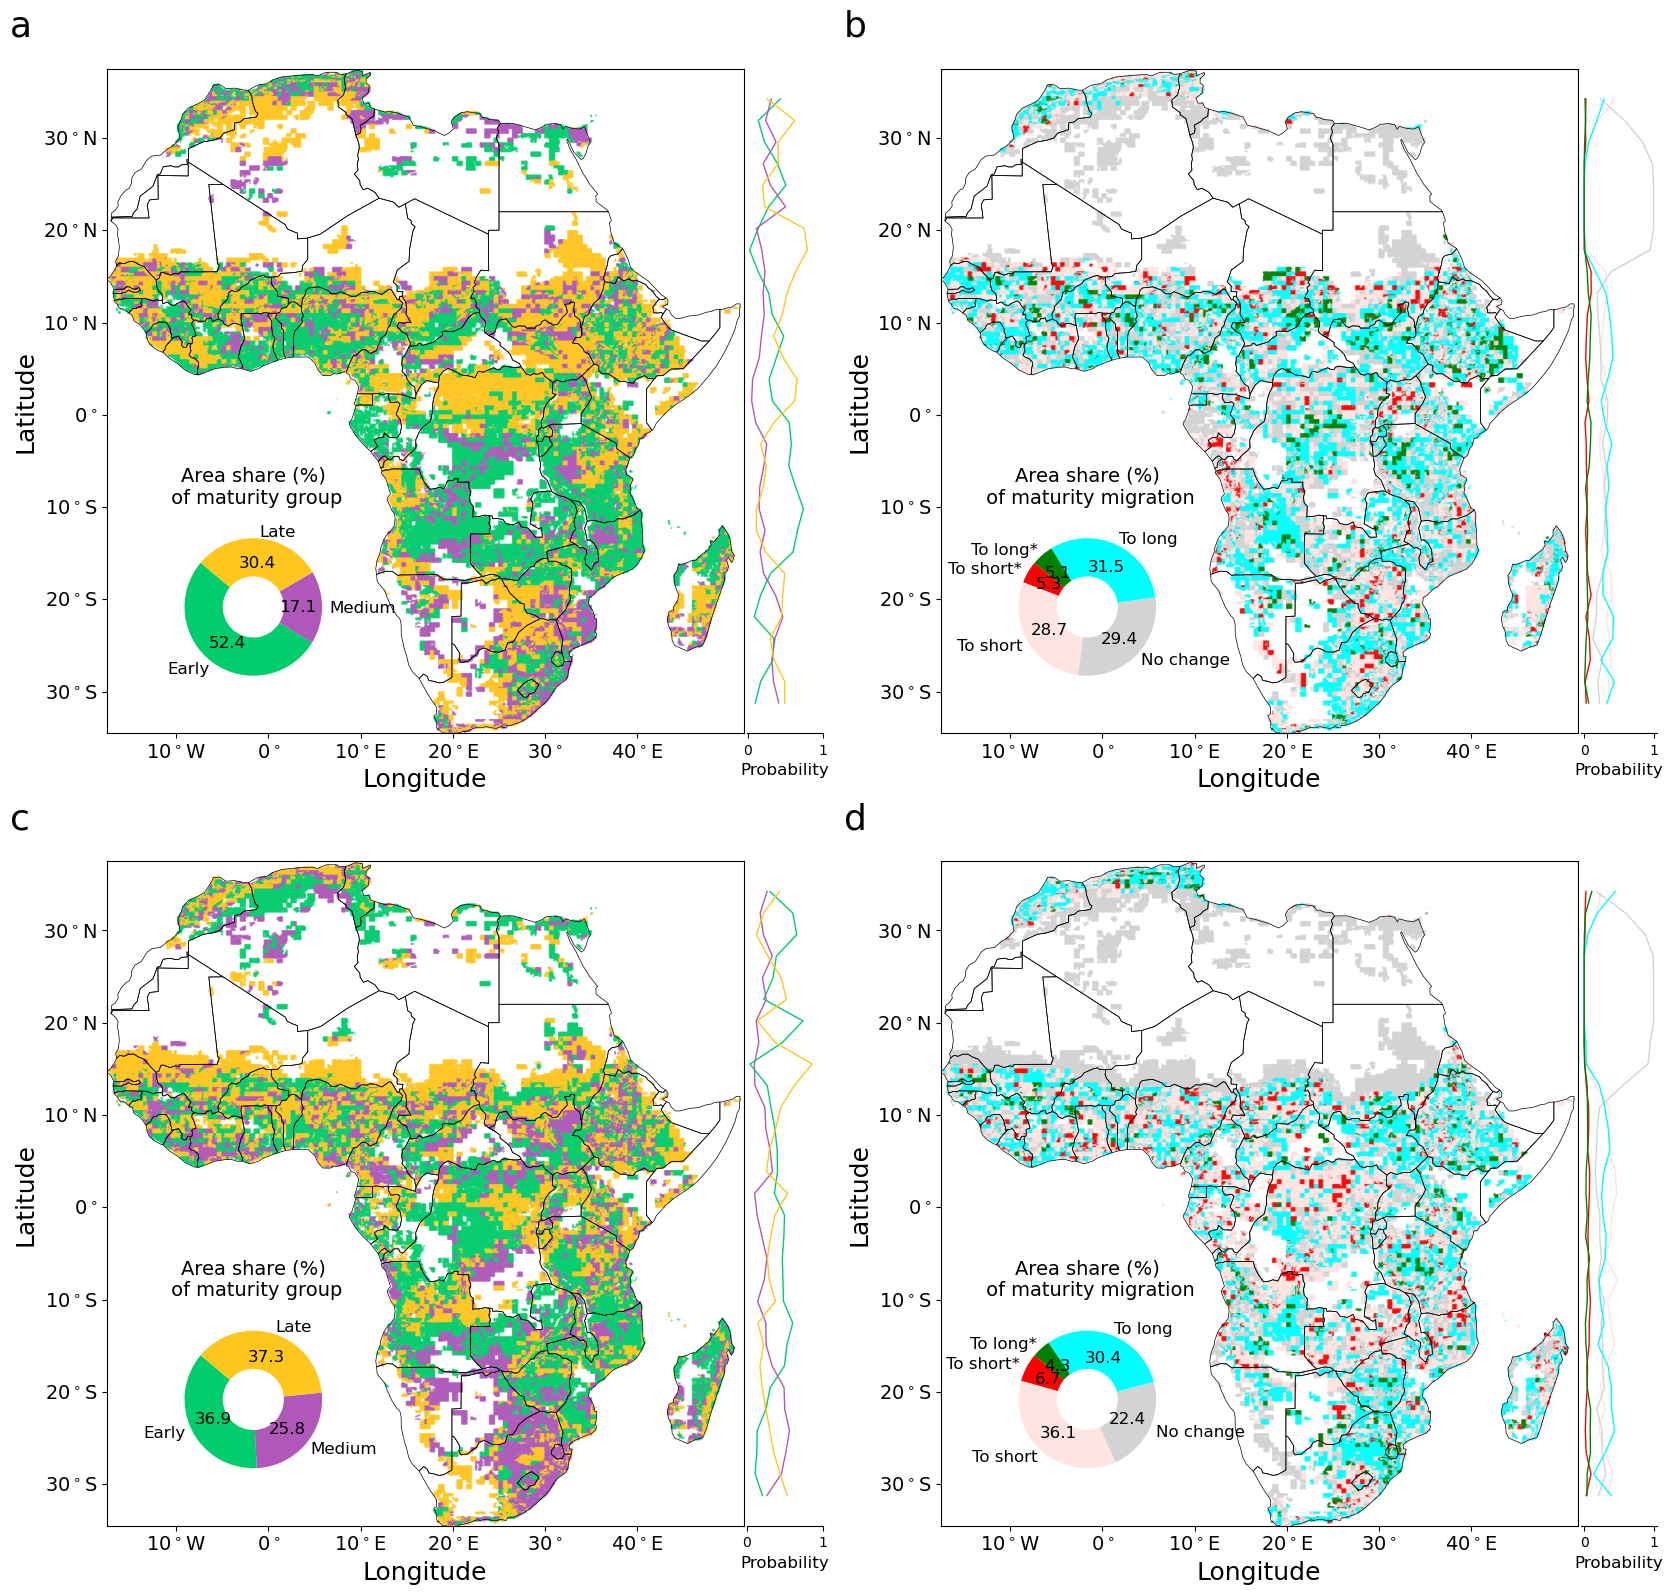

In [23]:
crop="mz"
fer="wofer_wa38hi40"  #
G1="_GT0.2"
"""
Plotting
"""
in_dir="D:\\works\\AfricaMzSg\\results\\"+crop+"\\"+fer+"\\"
tif_dir="D:\\works\\AfricaMzSg\\results\\"+crop+"\\"+fer+"\\"
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\"
#Define color
type_colors = [{-1: "#00CD6C", 0: "#AF58BA", 1: "#FFC61E"},
               {-2: "red", -1: "mistyrose", 0: "lightgrey", 1: "cyan", 2: "green"}] #blue, red, green, maturity type 
change_colors = {-2: "red", -1: "mistyrose", 0: "lightgrey", 1: "cyan", 2: "blue"} #change
#African country bounday
africa=gpd.read_file(fig_dir+"CountryBoundaryLines\\ne_110m_admin_0_countries.shp")
africa=africa[africa['CONTINENT']=='Africa']
#type_colors = {-1: "#E9002D", 0: "#FFAA00", 1: "#00B000"}  #Red Amber Green
tif_type=['dis','change']
pie_title=['Area share (%)\n of maturity group','Area share (%)\n of maturity migration']
pie_label=[['Early','Medium','Late'],
           ['To short*','To short','No change','To long','To long*']]
pie_radius=[0.9,0.9]
#grid include maize area
grid=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")[['POINT_X','POINT_Y','A']]
grid.columns=['x','y','A']
fig, axs = plt.subplots(2,2,figsize=(16.8,16))
#axs.axis("off") 
for i,j in list(itertools.product(range(2),range(2))):  #i=season, j=dist or change
    tif=tif_dir+"mz_se"+str(i+1)+"_"+fer+"_"+tif_type[j]+G1+".tiff"  #tif file for plotting
    df=pd.read_csv(in_dir+"mz_se"+str(i+1)+"_"+fer+"_"+tif_type[j]+G1+".csv") #data file for computer area sharing
    df=df.merge(grid).dropna()[['value','A']] #only leave value and Area columns
    with rasterio.open(tif) as src:
        tif = src.read(1)  # 读取第一个波段数据
        transform = src.transform  # 获取仿射变换参数
    #Acquire row and col number
    rows, cols = np.meshgrid(np.arange(tif.shape[0]),np.arange(tif.shape[1]),indexing='ij')  # 获取地理范围
    #Convert row and col to geospatial coordination
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)
    #Convert grid value and latitude longitude into dataframe
    data = pd.DataFrame({
        "longitude": xs.ravel(),
        "latitude": ys.ravel(),
        "value": tif.ravel()
    })
    #remove NaN values
    data = data[data["value"] != src.nodata]

    #Convert data into GeoDataFrame
    geometry = [Point(xy) for xy in zip(data["longitude"], data["latitude"])]
    geo_data = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")
       
    #main distribution plot at the middle
    ax_main = axs[i,j]
    africa.boundary.plot(ax=ax_main, linewidth=0.5, color="black")
    geo_data.plot(
        ax=ax_main,
        column="value",
        cmap=plt.cm.colors.ListedColormap([type_colors[j][key] for key in [*type_colors[j]]]),
        #legend=True,
        markersize=0.1)
    
    #ax_main.set_title("Maize maurity group distribution",fontsize=16)
    ax_main.set_xlabel("Longitude", fontsize=18)
    ax_main.set_ylabel("Latitude", fontsize=18)
    ax_main.set_xlim([-17.5,51.5])
    ax_main.set_ylim([-34.5,37.5])
    ax_main.set_xticks([-10,0,10,20,30,40],
                       ['$10^\circ$W','$0^\circ$','$10^\circ$E','$20^\circ$E','$30^\circ$',
                        '$40^\circ$E'],fontsize=14)
    ax_main.set_yticks([-30,-20,-10,0,10,20,30],
                       ['$30^\circ$S','$20^\circ$S','$10^\circ$S','$0^\circ$','$10^\circ$N','$20^\circ$N',
                        '$30^\circ$N'],fontsize=14)
    
    #Pie plot at the left bottom
    ax_pie = ax_main.inset_axes([0.08,0.04,0.3,0.3])   
    sizes = (df.groupby('value').sum()*100/df['A'].sum()).reset_index()['A'].tolist() #[-1,0,1]
    ax_pie.pie(sizes, 
               labels=pie_label[j],  #
               textprops={'fontsize': 12},
               radius=pie_radius[i],
               colors=[type_colors[j][key] for key in [*type_colors[j]]], 
               autopct=lambda pct: f'{pct:.1f}',
               pctdistance=0.65, 
               labeldistance=1.1, 
               rotatelabels=False,
               wedgeprops=dict(width=0.5),
               startangle=-220)
               #autopct=lambda pct: f'{pct:.1f}', startangle=90, wedgeprops=dict(width=0.5))  #'%1.0f%%'
    ax_pie.set_title(pie_title[j],fontsize=14)
    ax_pie.set_aspect('equal')
    ax_pie.set_xticks([])
    ax_pie.set_yticks([])
    
     #KDE plt at right
    ax_dist = ax_main.inset_axes([1.005,0,0.12,1])
    
    latitude_bins = np.linspace(data["latitude"].min(), data["latitude"].max(), 30)
    data["latitude_bins"]=pd.cut(data["latitude"],bins=latitude_bins,include_lowest=True)
    p_table=data.groupby(['latitude_bins','value']).size().unstack(fill_value=0)
    p_table=p_table.div(p_table.sum(axis=1),axis=0)
    c_p=p_table.cumsum(axis=1)

    for value in [*type_colors[j]]:
        ax_dist.plot(p_table[value],
                    latitude_bins[:-1]+np.diff(latitude_bins)/2,
                    linewidth=1,
                    color=type_colors[j][value])
    ax_dist.set_yticks([])
    ax_dist.set_xticks([0,1])
    ax_dist.spines['right'].set_visible(False)
    ax_dist.spines['top'].set_visible(False)
    ax_dist.spines['left'].set_visible(False)
    ax_dist.set_xlabel("Probability",fontsize=12)
for i in range(4):axs[i//2,i%2].text(-28,41,chr(97+i),fontsize=26)

plt.subplots_adjust(wspace=0.03,hspace=0.16)      
fig.tight_layout()
plt.show()
fig.savefig(fig_dir+"MS\\wofer\\MS1_mz_cul_distribution_change_"+fer+G1+".png",format="png",dpi=300)
fig.savefig(fig_dir+"MS\\wofer\\MS1_mz_cul_distribution_change_"+fer+G1+".pdf",format="pdf",dpi=300)

In [13]:
fig.savefig(fig_dir+"MS\\wofer\\MS1_mz_cul_distribution_change_"+fer+G1+".png",format="png",dpi=300)
fig.savefig(fig_dir+"MS\\wofer\\MS1_mz_cul_distribution_change_"+fer+G1+".pdf",format="pdf",dpi=300)